In [ ]:
#This project is to customize a pretrained CNN model MobileNet by tensorflow 
#keras API to detect 4 kinds of object, train, car, sheep, bus
import numpy as np
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)
%matplotlib inline

os.getcwd()

#Import pretrained model to be modified later
mobile=tf.keras.applications.mobilenet.MobileNet()

#Function to process image data for later training
def prepare_image(file):
    img_path='Resources/'
    img=image.load_img(img_path+file,target_size=(224,224))
    img_array=image.img_to_array(img)
    img_array_expanded_dims=np.expand_dims(img_array,axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

#Define object classes and data folders and amount of data to be used for training, validation, testing 
objToDetect=['car','train','bus','sheep']
trainigSize={'training':300,'valid':10,'test':5}
for folder,imageAmount in trainigSize.items():
    print(folder,imageAmount)

#Empty folder 'temp' and copy images from downloaded image data from VOCdevkit 2012 to folder 'temp'
folder = 'temp'
for the_file in os.listdir(folder):
    file_path = os.path.join(folder, the_file)
    try:
        if os.path.isfile(file_path):
            os.remove(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
          print(e)            

for objname in objToDetect:
    os.mkdir(f'temp/{objname}')
    
    #label information saved in ''*_trainval.txt
    with open(f'VOCdevkit\\VOC2012\\ImageSets\\Main\\{objname}_trainval.txt') as textFile: 
        lines = [line.split() for line in textFile]
        count=0
        filepaths=[]
        for id in lines:
            x=id[1]
            if id[1]=='1':
                count+=1
                filepath='VOCdevkit\VOC2012\JPEGImages\\'+id[0]+'.jpg'
                #filepaths.append(filepath)
                filepath_new=f'temp/{objname}/'+id[0]+'.jpg'
                shutil.copyfile(filepath,filepath_new)

#Empty folder 'tfkeras1' and move images from 'temp' to folder 'tfkeras1/*/*'
folder = 'tfkeras1'
for the_file in os.listdir(folder):
    file_path = os.path.join(folder, the_file)
    try:
        if os.path.isfile(file_path):
            os.remove(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
          print(e)

for folder,imageAmount in trainigSize.items():
    for objname in objToDetect:
        folderpath=os.path.join('tfkeras1',folder,objname)
        if os.path.isdir(folderpath) is False:    
            os.makedirs(folderpath)
        if not os.listdir(folderpath):
         
            for c in random.sample(glob.glob(f'temp/{objname}/*'),imageAmount):
                shutil.move(c,folderpath)

#Define path variable for creating training batches
train_path='tfkeras1/training'
valid_path='tfkeras1/valid'
test_path='tfkeras1/test'
    

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
.flow_from_directory(directory=train_path,target_size=(224,224),batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
.flow_from_directory(directory=valid_path,target_size=(224,224),batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
.flow_from_directory(directory=test_path,target_size=(224,224),batch_size=10,shuffle=False)

#Modify pretrained model
x=mobile.layers[-6].output
output=Dense(units=4,activation='softmax')(x)

#Modify pretrained model
model=Model(inputs=mobile.input,outputs=output)

#Modify pretrained model
for layer in model.layers[:-23]:
    layer.trainable=False

#Modification finished
model.summary()

#Compile modified model
model.compile(optimizer=Adam(learning_rate=0.0001),loss="categorical_crossentropy",metrics=['accuracy'])

#Train modified model
model.fit(x=train_batches,validation_data=valid_batches,epochs=10,verbose=2)

test_labels=test_batches.classes

predictions=model.predict(x=test_batches,verbose=0)

cm=confusion_matrix(y_true=test_batches.classes,y_pred=np.argmax(predictions,axis=-1))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


cm_plot_labels=['bus','car','sheep','train']
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title='Confusion_matrix')

def prepare_image(file):
    img_path='Resources'
    img=image.load_img(os.path.join(img_path,file),target_size=(50,50))
    img_array=image.img_to_array(img)
    img_array_expanded_dims=np.expand_dims(img_array,axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

# imagefile='5.jpg'


# from IPython.display import Image
# Image(filename=f'Resources/{imagefile}',width=300,height=200)

# preprocessed_image=prepare_image(imagefile)
# predictions=model.predict(preprocessed_image)
# predicted_class = np.argmax(predictions)
# cm_plot_labels[predicted_class]

# os.chdir('C:\\Users\\Serena\\Documents\\Education\\python')

Sample image files in a folder to be predicted :
 Name of files: 
 ['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg']


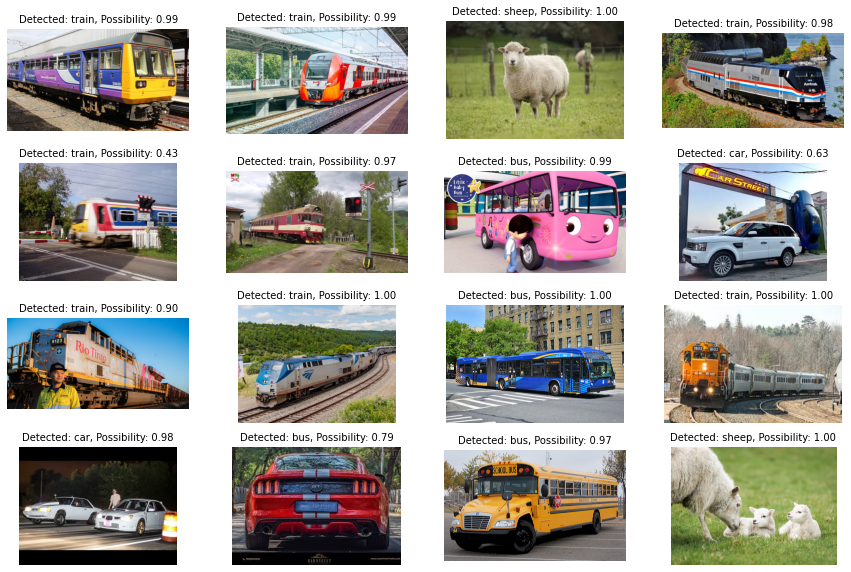

In [225]:
#Below code is to predict sample images saved in folder 'Resources'
import PIL
import re
nrows = 4
ncols = 4
fig,axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,10))

files = os.listdir('C:\\Users\\Serena\\Documents\\Education\\python\\Resources')
files.sort(key=lambda f: int(re.sub('\D', '', f)))
print('Sample image files in a folder to be predicted :\n Name of files: \n',files)

for num, imagefile in enumerate(files):
    img = PIL.Image.open(os.path.join('Resources',imagefile))

 
    preprocessed_image=prepare_image(imagefile)
    predictions=model.predict(preprocessed_image)
    predicted_class = np.argmax(predictions)
    name=cm_plot_labels[predicted_class]
    possibility=predictions[0][predicted_class]
 
    
    plt.subplot(nrows,ncols,num+1)
    plt.title(f'Detected: {name}, Possibility: {possibility:.2f}',fontsize=10)
    plt.axis('off')
    plt.imshow(img)